In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%cd ..

/cis/home/dpacker/my_documents/equivariant-attention


In [23]:
from models import vanilla_attention, positional_encodings
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
rng = jax.random.PRNGKey(seed=1)
rngs = jax.random.split(rng, 10)

In [3]:
# Let's learn the sine function on the circle:
N = 100

X_train = jax.random.normal(key=rngs[0], shape=(N, 2))
X_train /= jnp.linalg.norm(X_train, axis = -1)[:, None]
X_test = jax.random.normal(key=rngs[1], shape=(N, 2))
X_test /= jnp.linalg.norm(X_test, axis = -1)[:, None]
sin_X_train = X_train[:, 1:]
sin_X_test = X_test[:, 1:]

n = 20
keys = jax.random.normal(key=rngs[2], shape=(n, 2))
values = jax.random.normal(key=rngs[3], shape=(n, 1))

In [4]:
epochs = 10000
keys_hist = jnp.zeros([epochs, *keys.shape])
values_hist = jnp.zeros([epochs, *values.shape])

for i in range(epochs):
  keys_hist = keys_hist.at[i].set(keys)
  values_hist = values_hist.at[i].set(values)
  keys, values = vanilla_attention.update([keys, values], X_train, sin_X_train, lr=0.01)

2023-11-15 09:10:48.611533: W external/xla/xla/service/gpu/buffer_comparator.cc:1054] INTERNAL: ptxas exited with non-zero error code 65280, output: ptxas /tmp/tempfile-canton-f158e730-3927201-60a3178522bcf, line 10; fatal   : Unsupported .version 7.8; current version is '7.6'
ptxas fatal   : Ptx assembly aborted due to errors

Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only be logged once.


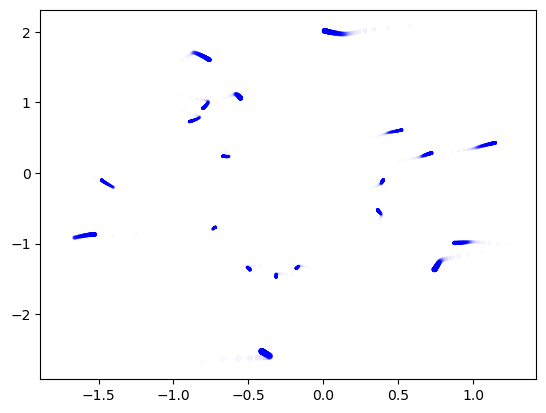

In [5]:
# plt.scatter(keys[:,0], keys[:, 1])
for i in range(0, epochs, int(epochs / 100)):
  plt.scatter(keys_hist[i, :, 0], keys_hist[i, :, 1], alpha=i/epochs, color="blue", s=jnp.exp(jnp.abs(values_hist[i, :, 0])))

In [6]:
print(f"Training Loss: {vanilla_attention.loss([keys, values], X_train, sin_X_train)}")
print(f"Test Loss: {vanilla_attention.loss([keys, values], X_test, sin_X_test)}")

# Look how small that loss is!

Training Loss: 0.00023146352032199502
Test Loss: 0.0002520708949305117


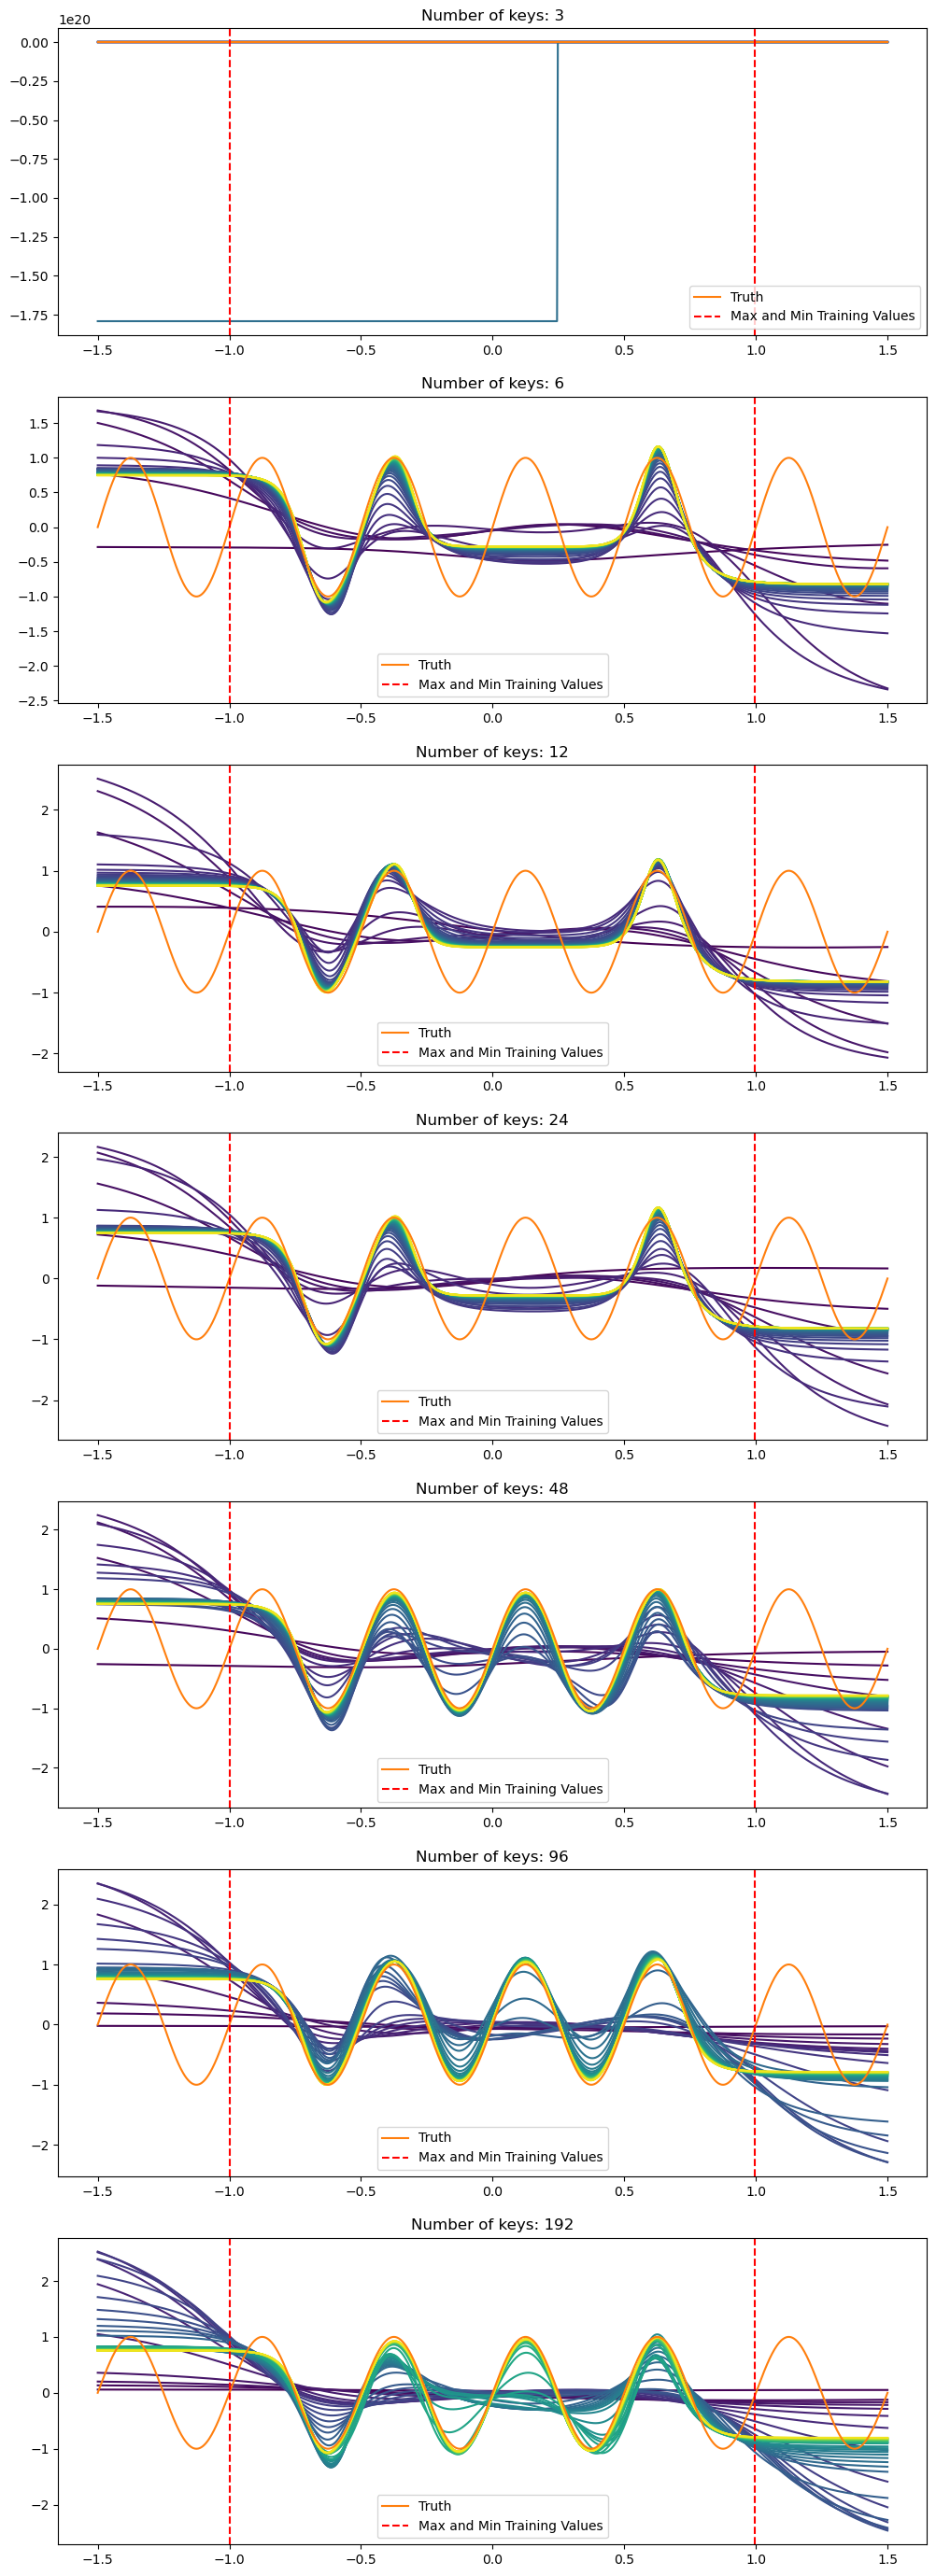

In [58]:
# Now, let's try to learn a function on the ball, using positional encodings:
# We'll still try to learn sine, but it's more complicated now!
n_train = 1000
n_epochs = 10_000
k = 4
n_keys_list = [3, 6, 12, 24, 48, 96, 192]
fig, axs = plt.subplots(len(n_keys_list), 1, figsize=(12, len(n_keys_list) * 5))

for i, n_keys in enumerate(n_keys_list):
  f = lambda X : jnp.sin(jnp.pi * k * X)
  X_train = jax.random.uniform(rngs[3], shape=[n_train], minval = -1, maxval = 1)[:, None]

  stereographic_encoding = lambda X : positional_encodings.positional_encoding(X, method="stereographic")
  keys_hist, values_hist = vanilla_attention.train(rng, X_train, stereographic_encoding, n_keys, n_epochs = n_epochs, lr = 2.0, f=f, verbose = False)
  cmap = colormaps.get_cmap('viridis')

  vanilla_attention.plot_predictions(stereographic_encoding, keys_hist, values_hist, cmap, axs[i])

  axs[i].plot(X_test, f(X_test), color="C1", label = "Truth")
  axs[i].axvline(x = jnp.min(X_train), color = "red", linestyle = "dashed", label = "Max and Min Training Values")
  axs[i].axvline(x = jnp.max(X_train), color = "red", linestyle = "dashed")
  axs[i].set(title = f"Number of keys: {n_keys}")
  axs[i].legend()

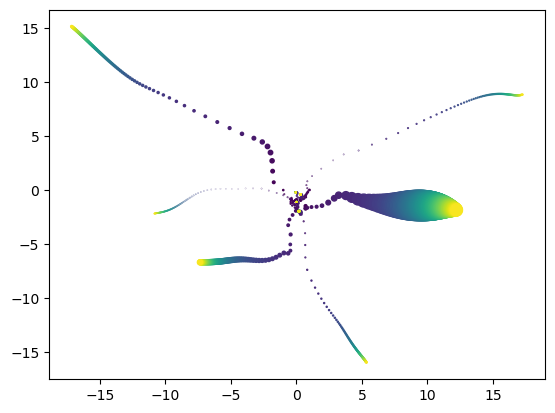

In [97]:
keys_hist, values_hist = vanilla_attention.train(rng, X_train, stereographic_encoding, 10, n_epochs = n_epochs, lr = 2.0, f=f, verbose = False)

for i in range(0, epochs, int(epochs / 100)):
  plt.scatter(keys_hist[i, :, 0], keys_hist[i, :, 1], color=cmap(i / epochs), s=jnp.exp(values_hist[i, :, 0]), edgecolor=None)

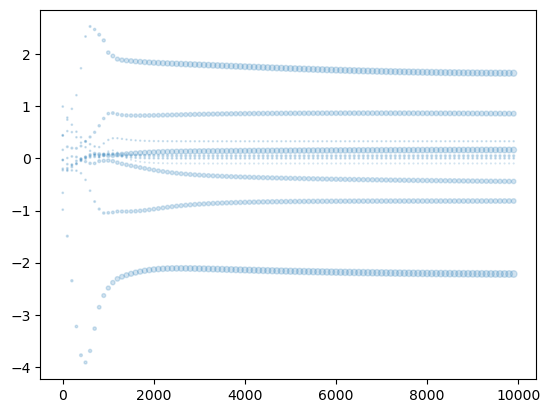

In [98]:
def get_dir_norm(keys):
  norm = jnp.linalg.norm(keys, axis = -1)
  return norm, keys / norm[:, None]

for i in range(0, epochs, int(epochs / 100)):
  keys = keys_hist[i]
  values = values_hist[i]
  norms, normed_keys = get_dir_norm(keys)
  decoded_keys = positional_encodings.positional_decoding(normed_keys, method="stereographic")
  plt.scatter(jnp.full(decoded_keys.shape[0], i), decoded_keys[:, 0], color="C0", alpha=0.2, s=(norms), edgecolor=None)

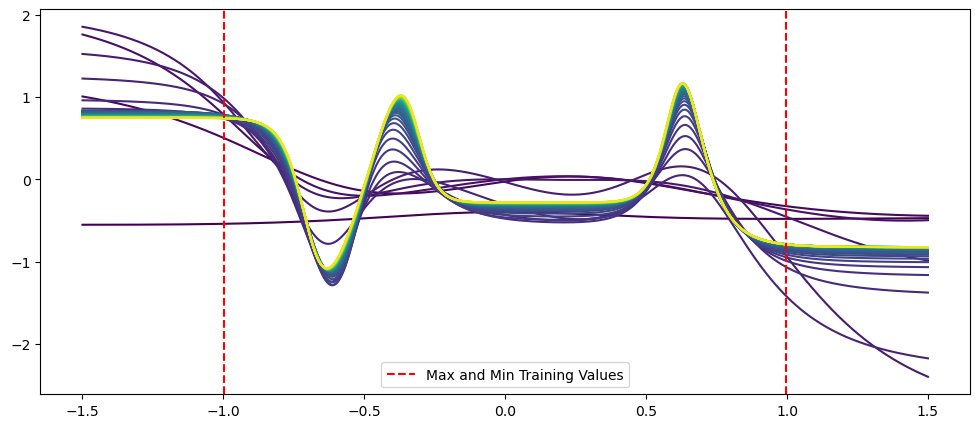

In [101]:
fig, ax = plt.subplots(figsize=(12, 5))
X_test = jnp.linspace(-1.5, 1.5, num=1_000)[:, None]
vanilla_attention.plot_predictions(stereographic_encoding, keys_hist, values_hist, cmap, ax, X_test = X_test)
# ax.plot(X_test, f(X_test), color="C1", label = "Truth")
ax.axvline(x = jnp.min(X_train), color = "red", linestyle = "dashed", label = "Max and Min Training Values")
ax.axvline(x = jnp.max(X_train), color = "red", linestyle = "dashed")
# ax.set(title = f"Number of keys: {n_keys}")
ax.legend()

In [73]:
ex_data

Array([[ 0.9234944 , -0.87258184,  0.7147156 , -0.98624027,  1.2036945 ],
       [-2.0438585 ,  0.8667447 , -2.0618372 , -1.2421507 , -0.8150188 ],
       [ 1.3687463 , -0.8441721 ,  0.9880241 ,  0.12877433,  0.35790065],
       [ 0.24222897,  1.1035267 , -0.54574656,  0.9105978 , -0.22211416],
       [ 1.7892947 ,  1.2641075 ,  0.2665897 , -0.58670884, -0.7603085 ],
       [ 0.5341307 ,  0.65932465,  0.8946061 ,  1.9624286 , -0.22163457],
       [ 2.0208774 , -0.29255918,  1.1174265 ,  0.3926005 , -0.8605959 ],
       [ 0.3116847 ,  0.56486213,  0.00294757, -0.20374012,  0.45888147],
       [-0.12984356,  0.0554036 , -0.08677173, -0.7461134 ,  1.1040246 ],
       [ 0.14956993, -1.1534116 ,  0.08976839,  0.10260768,  0.86074317],
       [-0.05321621,  1.5761908 ,  0.65925515,  0.60585093, -0.30963397],
       [ 0.6018875 ,  0.19289091, -0.24503978,  0.97589195, -0.2905204 ],
       [ 0.32262924,  0.6159478 , -0.59138364,  0.16983682, -2.2720654 ],
       [ 0.88486093,  0.04780211, -0.2